Show how changing the parameters affects the MEG response. Additionally, try changing the distribution.

In [11]:
from collections import namedtuple, OrderedDict
import os

import h5py
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import nengo
from nengo.utils.ensemble import tuning_curves
import nengolib
import nengo_spa as spa

from nengo_learn_assoc_mem.utils import (numpy_bytes_to_str, norm_spa_vecs, BasicVecFeed)
from nengo_learn_assoc_mem.paths import data_path

# Setup

In [12]:
with h5py.File(os.path.join(data_path, "neg_voja_enc.h5"), "r") as fi:
    print(list(fi.keys()))

    fan1 = numpy_bytes_to_str(fi['fan1'])
    fan2 = numpy_bytes_to_str(fi['fan2'])
    foil1 = numpy_bytes_to_str(fi['foil1'])
    foil2 = numpy_bytes_to_str(fi['foil2'])

    v_strs = numpy_bytes_to_str(fi['vocab_strings'])
    v_vecs = list(fi['vocab_vectors'])
    dimensions = fi['vocab_vectors'].attrs['dimensions']
    
    fin_enc = np.array(fi['encoders'])
    n_neurons = fin_enc.shape[0]
    intercepts = [fi['encoders'].attrs['intercept']] * n_neurons
    seed = fi['encoders'].attrs['seed']

    dt = fi['t_range'].attrs['dt']

['encoders', 'fan1', 'fan2', 'foil1', 'foil2', 't_range', 'vocab_strings', 'vocab_vectors']


In [13]:
vocab = spa.Vocabulary(dimensions)
for val, vec in zip(v_strs, v_vecs):
    vocab.add(val, vec)

fan1_pair_vecs = norm_spa_vecs(vocab, fan1)
fan2_pair_vecs = norm_spa_vecs(vocab, fan2)
foil1_pair_vecs = norm_spa_vecs(vocab, foil1)
foil2_pair_vecs = norm_spa_vecs(vocab, foil2)

In [14]:
t_pause = 0.5
t_present = 0.3

t_each = t_pause + t_present
td_each = int(t_each/dt)
td_pause = int(t_pause/dt)

In [15]:
fan1_slc = slice(td_pause, td_each*len(fan1_pair_vecs)+td_pause)
fan2_slc = slice(fan1_slc.stop, fan1_slc.stop+td_each*len(fan2_pair_vecs))
foil1_slc = slice(fan2_slc.stop, fan2_slc.stop+td_each*len(foil1_pair_vecs))
foil2_slc = slice(foil1_slc.stop, foil1_slc.stop+td_each*len(foil2_pair_vecs))

In [16]:
SlcStim = namedtuple("Stim", ['fan_num', 'targ', 'vecs', 'slc'])

slc_stim_vecs = {"fan1": SlcStim(1, True, np.array(fan1_pair_vecs), fan1_slc),
                 "fan2": SlcStim(2, True, np.array(fan2_pair_vecs), fan2_slc),
                 "foil1": SlcStim(1, False, np.array(foil1_pair_vecs), foil1_slc),
                 "foil2": SlcStim(2, False, np.array(foil2_pair_vecs), foil2_slc)}

In [80]:
def calc_linear_weights(base_inhib_mag: float, min_neg_w: float, max_pos_w: float) -> np.ndarray:
    with nengolib.Network(seed=seed) as model:
        ens = nengo.Ensemble(n_neurons, dimensions,
                             encoders=fin_enc.copy(), intercepts=intercepts, seed=seed)

    with nengo.Simulator(model) as sim:
        pass
    
    feed_vecs = fan1_pair_vecs + fan2_pair_vecs
    _, activities = tuning_curves(ens, sim, inputs=np.array(feed_vecs))
    
    mean_act = np.mean(activities, axis=0)
    act_corr = np.zeros((n_neurons, n_neurons), dtype=np.float)

    for v_i in range(len(feed_vecs)):
        act_corr += np.outer(activities[v_i]-mean_act, activities[v_i])
    
    np.fill_diagonal(act_corr, 0)

    max_corr = np.max(act_corr)
    min_corr = np.min(act_corr)
    
    pos_corr = act_corr[act_corr > 0.]
    min_pos_corr = np.min(pos_corr)
    neg_corr = act_corr[act_corr < 0.]
    max_neg_corr = np.max(neg_corr)
    
    rec_w = np.ones((n_neurons, n_neurons), dtype=np.float) * base_inhib_mag
    rec_w[act_corr > 0.] = np.interp(pos_corr,
                                     (min_pos_corr, max_corr),
                                     (base_inhib_mag, max_pos_w)) 
    rec_w[act_corr < 0.] = np.interp(neg_corr,
                                     (min_corr, max_neg_corr),
                                     (min_neg_w, base_inhib_mag)) 
    np.fill_diagonal(rec_w, 0)
    
    return rec_w

In [81]:
def weight_eval(rec_weights: np.ndarray, rec_synapse=0.01):
    feed_vecs = fan1_pair_vecs + fan2_pair_vecs + foil1_pair_vecs + foil2_pair_vecs
    
    feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

    with nengolib.Network(seed=seed) as learned_model:
        in_nd = nengo.Node(feed.feed)
        pause = nengo.Node(lambda t: feed.paused)
        meg_node = nengo.Node(lambda t, x: np.sum(x), size_in=n_neurons, size_out=1)

        ens = nengo.Ensemble(n_neurons, dimensions,
                             encoders=fin_enc.copy(), intercepts=intercepts, seed=seed)

        nengo.Connection(in_nd, ens, synapse=None)
        nengo.Connection(pause, ens.neurons, transform=-10*np.ones((n_neurons, 1)), synapse=None)
        nengo.Connection(ens.neurons, ens.neurons, transform=rec_weights, synapse=rec_synapse)
        nengo.Connection(ens.neurons, meg_node, synapse=None)

        p_in = nengo.Probe(in_nd)
        p_meg = nengo.Probe(meg_node, synapse=0.05)

    with nengo.Simulator(learned_model) as learned_sim:
        learned_sim.run(len(feed_vecs)*t_each + t_pause)
        
    return learned_sim.trange(), learned_sim.data[p_meg]

In [82]:
def get_meg_df(meg_res):
    df_list = []

    for key, obj in slc_stim_vecs.items():
        act = meg_res[obj.slc]
        resp = [obj.fan_num] * len(act)
        targ = [obj.targ] * len(act)
        df_list.append(pd.DataFrame({"act": act, "resp": resp, "targ": targ}))

    return pd.concat(df_list)

In [83]:
def plt_meg(t_range, meg_res):
    plt.figure(figsize=(12, 3))
    plt.plot(t_range[fan1_slc], meg_res[fan1_slc], linestyle=":")
    plt.plot(t_range[fan2_slc], meg_res[fan2_slc], linestyle=":")
    
    plt.figure(figsize=(12, 3))
    plt.plot(t_range[foil1_slc], meg_res[foil1_slc], linestyle=":")
    plt.plot(t_range[foil2_slc], meg_res[foil2_slc], linestyle=":")
    
    act_df = get_meg_df(meg_res)
    
    plt.figure()
    ax = sns.barplot(x="resp", y="act", hue="targ", data=act_df)

    ax.set_title("Difference between FAN1 and FAN2 firing rates")
    ax.set_ylabel("Mean Firing Rate")
    ax.set_xlabel("FAN type")

    ax.legend_.set_title("Target vs. Foil")
    ax.legend_.set_bbox_to_anchor((1, 0.8))
    new_labels = ("Foil", "Target")
    for t, l in zip(ax.legend_.texts, new_labels): t.set_text(l)
    
    return act_df

In [84]:
def eval_meg(rec_weights: np.ndarray, rec_synapse=0.01):
    t_range, meg_res = weight_eval(rec_weights, rec_synapse)
    
    plt_meg(t_range, meg_res)

## Effect of base inhibition

In [85]:
base_inhib_vals = (0, -5e-6, -5e-5, -5e-4)
max_excite = 5e-4
max_inhib = -7e-3

In [86]:
df_list = []

for base_inhib in base_inhib_vals:
    rec_w = calc_linear_weights(base_inhib, max_inhib, max_excite)
    t_range, meg_sig = weight_eval(rec_w)
    df_list.append(get_meg_df(meg_sig.flatten()).assign(base_inhib=base_inhib))

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

In [87]:
all_bases = pd.concat(df_list)

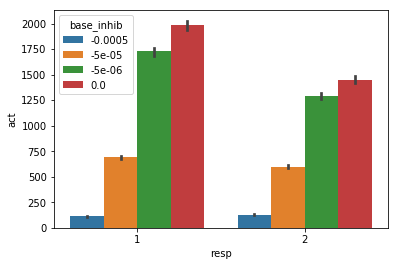

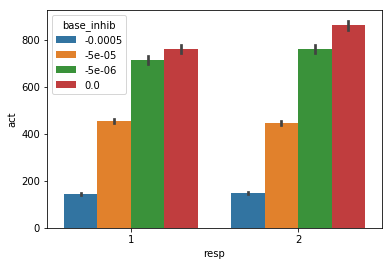

In [88]:
plt_df = all_bases[(all_bases.targ == True)]
plt.figure()
sns.barplot(x="resp", y="act", hue="base_inhib", data=plt_df);

plt_df = all_bases[all_bases.targ == False]
plt.figure()
sns.barplot(x="resp", y="act", hue="base_inhib", data=plt_df);

In [89]:
# plot the means

## Effect of maximum excitation

In [90]:
base_inhib = -5e-5
max_excite_vals = (9e-4, 5e-4, 1e-4)
max_inhib = -7e-3

In [91]:
df_list = []

for max_excite in max_excite_vals:
    rec_w = calc_linear_weights(base_inhib, max_inhib, max_excite)
    t_range, meg_sig = weight_eval(rec_w)
    df_list.append(get_meg_df(meg_sig.flatten()).assign(excite=max_excite))

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

In [92]:
all_excites = pd.concat(df_list)

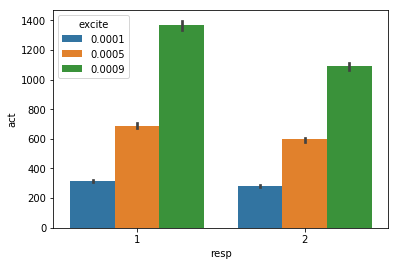

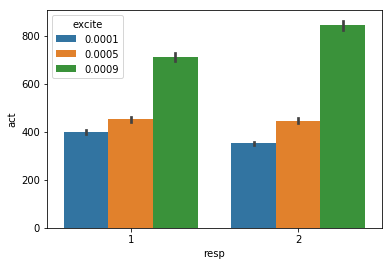

In [93]:
plt_df = all_excites[(all_excites.targ == True)]
plt.figure()
sns.barplot(x="resp", y="act", hue="excite", data=plt_df);

plt_df = all_excites[all_excites.targ == False]
plt.figure()
sns.barplot(x="resp", y="act", hue="excite", data=plt_df);

## Effect of maximum inhibition

In [94]:
base_inhib = -5e-5
max_excite = 5e-4
max_inhib_vals = (-7e-4, -7e-3, -7e-2)

In [95]:
df_list = []

for max_inhib in max_inhib_vals:
    rec_w = calc_linear_weights(base_inhib, max_inhib, max_excite)
    t_range, meg_sig = weight_eval(rec_w)
    df_list.append(get_meg_df(meg_sig.flatten()).assign(max_inhib=max_inhib))

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

In [96]:
all_inhibs = pd.concat(df_list)

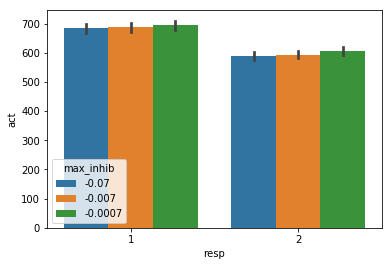

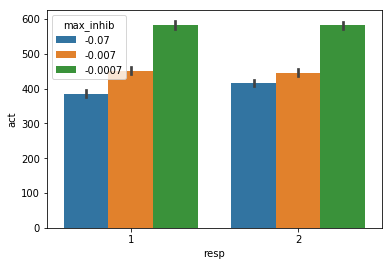

In [97]:
plt_df = all_inhibs[(all_inhibs.targ == True)]
plt.figure()
sns.barplot(x="resp", y="act", hue="max_inhib", data=plt_df);

plt_df = all_inhibs[all_inhibs.targ == False]
plt.figure()
sns.barplot(x="resp", y="act", hue="max_inhib", data=plt_df);